# Access Climate Model Output Using `Zarr.jl`

- Access climate model archive ([CMIP6](https://esgf-node.llnl.gov/search/cmip6/)) via `AWSCore.jl` and `Zarr.jl` 
- Choose `institution_id`, `source_id`, `variable_id`
- Compute and plot (1) time mean global map and (2) time evolving global mean

_This notebook was partly inspired by [this earlier example](https://github.com/pangeo-data/pangeo-julia-examples) from @rabernat_

In [1]:
#initialize julia packages and connection to cloud storage

using Zarr, AWSCore, DataFrames, CSV, CFTime, Dates, Statistics, Plots

⅁ = AWSCore.aws_config(creds=nothing, region="", 
    service_host="googleapis.com", service_name="storage")
#println(typeof(⅁))
#println(supertype(typeof(⅁)))

Dict{Symbol,Any} with 4 entries:
  :service_name => "storage"
  :service_host => "googleapis.com"
  :creds        => nothing
  :region       => ""

In [2]:
#get list of contents for cloud storage unit

β = S3Store("cmip6","", aws=⅁, listversion=1)
#println(typeof(β))

ξ = CSV.read(IOBuffer(β["cmip6-zarr-consolidated-stores.csv"]))
unique(ξ[!,:activity_id])
#unique(ξ[!,:institution_id])

15-element Array{String,1}:
 "AerChemMIP" 
 "C4MIP"      
 "CFMIP"      
 "CMIP"       
 "DAMIP"      
 "DCPP"       
 "FAFMIP"     
 "GMMIP"      
 "HighResMIP" 
 "LS3MIP"     
 "LUMIP"      
 "OMIP"       
 "PMIP"       
 "RFMIP"      
 "ScenarioMIP"

In [3]:
#choose model and variable

S=["IPSL","IPSL-CM6A-LR","tas"] #institution_id, source_id, variable_id

# get model grid cell areas

ii=findall( (ξ[!,:source_id].==S[2]).&(ξ[!,:variable_id].=="areacella") )
μ=ξ[ii,:]
i1=findfirst("cmip6",μ.zstore[end])[end]+2
P = μ.zstore[end][i1:end]

ζ = zopen(S3Store("cmip6", P, aws=⅁, listversion=1))
Å = ζ["areacella"][:, :];

#heatmap(ζ["lon"], ζ["lat"], transpose(Å))

## Plot One Model Solution

Here we first select one ensemble member for the chosen model. We then compute and plot a (1) time mean global map and (2) time evolving global mean

In [4]:
# get model solution ensemble list

i=findall( (ξ[!,:activity_id].=="CMIP").&(ξ[!,:table_id].=="Amon").&
            (ξ[!,:variable_id].==S[3]).&(ξ[!,:experiment_id].=="historical").&
            (ξ[!,:institution_id].==S[1]) )
μ=ξ[i,:]
unique(μ[!,:institution_id])

1-element Array{String,1}:
 "IPSL"

In [5]:
# access one model ensemble member

i1=findfirst("cmip6",μ.zstore[end])[end]+2
P = μ.zstore[end][i1:end]
ζ = zopen(S3Store("cmip6", P, aws=⅁, listversion=1))
size(ζ[S[3]])

(144, 143, 1980)

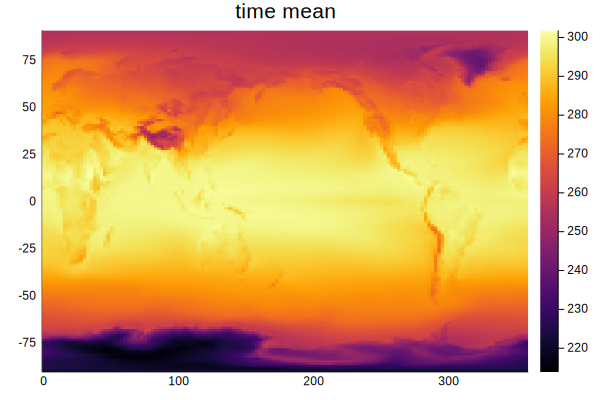

In [6]:
# time mean global map

m = convert(Array{Union{Missing, Float32},3},ζ[S[3]][:,:,:])
m = dropdims(mean(m,dims=3),dims=3)

heatmap(ζ["lon"], ζ["lat"], transpose(m),title="time mean")

In [10]:
# compute time evolving global mean

t = ζ["time"]
t = timedecode(t[:], t.attrs["units"], t.attrs["calendar"])

y = ζ[S[3]]
ylab=y.attrs["long_name"]*" in "*y.attrs["units"]

y=y[:,:,:]
y=[sum(y[:, :, i].*Å) for i in 1:length(t)]./sum(Å);

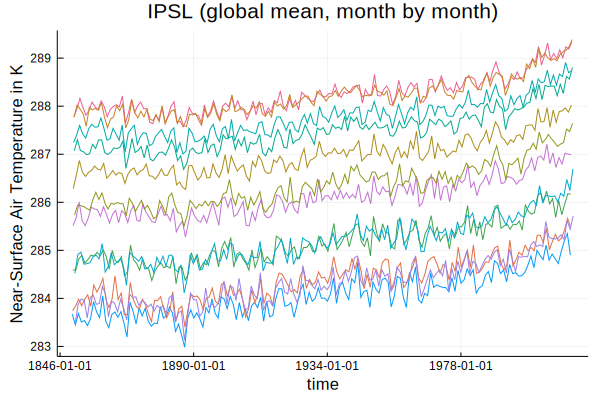

In [8]:
#plot by month to hightlight trend

plt=plot(t[1:12:end],y[1:12:end],xlabel="time",ylabel=ylab,title=S[1]*" (global mean, month by month)")
[plot!(t[i:12:end],y[i:12:end], leg = false) for i in 2:12]
display(plt)

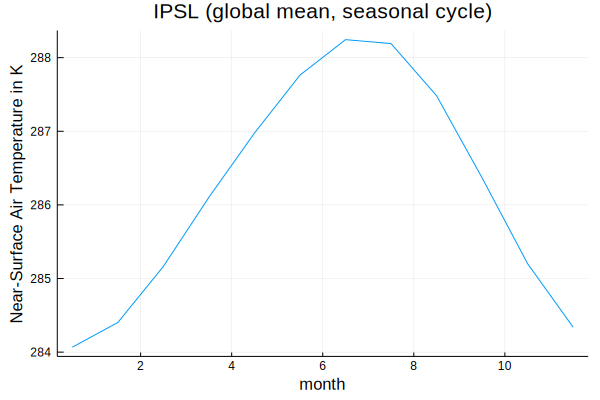

In [9]:
#plot time mean seasonal cycle

ny=Int(length(t)/12)
a_y=fill(0.0,(ny,12))
[a_y[:,i].=y[i:12:end] for i in 1:12]

plot([0.5:1:11.5],vec(mean(a_y,dims=1)), xlabel="month",ylabel=ylab, leg = false, title=S[1]*" (global mean, seasonal cycle)")